<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# 04. PyTorch Custom Datasets

In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?



<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*


We can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover

We're going to be applying the PyTorch Workflow to a computer vision problem, but instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*


| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## Where can can you get help?

All of the materials for this course [live on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions) there too.

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch.

## 0. Importing PyTorch and setting up device-agnostic code

In [3]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
print(torch.__version__)

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.8.0+cu126


'cuda'

## 1. Get data

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

> Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).


Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.
And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).



In [5]:
import requests
import zipfile
from pathlib import Path


# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

*Data preparation is paramount. Before building a model, become one with the data. Ask: What am I trying to do here? Source: [@mrdbourke Twitter](https://twitter.com/mrdbourke).*

Image classification format contains separate classes of images in separate directories titled with a particular class name.

> **Note**: This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).


The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

> **Note:** The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

In [15]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Dirpath:\n {dirpath}\nNumber of directories:\n {len(dirnames)}\nNumber of files:\n {len(filenames)}\n")

In [16]:
walk_through_dir(image_path)

Dirpath:
 data/pizza_steak_sushi
Number of directories:
 2
Number of files:
 0

Dirpath:
 data/pizza_steak_sushi/test
Number of directories:
 3
Number of files:
 0

Dirpath:
 data/pizza_steak_sushi/test/steak
Number of directories:
 0
Number of files:
 19

Dirpath:
 data/pizza_steak_sushi/test/sushi
Number of directories:
 0
Number of files:
 31

Dirpath:
 data/pizza_steak_sushi/test/pizza
Number of directories:
 0
Number of files:
 25

Dirpath:
 data/pizza_steak_sushi/train
Number of directories:
 3
Number of files:
 0

Dirpath:
 data/pizza_steak_sushi/train/steak
Number of directories:
 0
Number of files:
 75

Dirpath:
 data/pizza_steak_sushi/train/sushi
Number of directories:
 0
Number of files:
 72

Dirpath:
 data/pizza_steak_sushi/train/pizza
Number of directories:
 0
Number of files:
 78



In [17]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/test/pizza/3092704.jpg
Image class: pizza
Image height: 512
Image width: 512


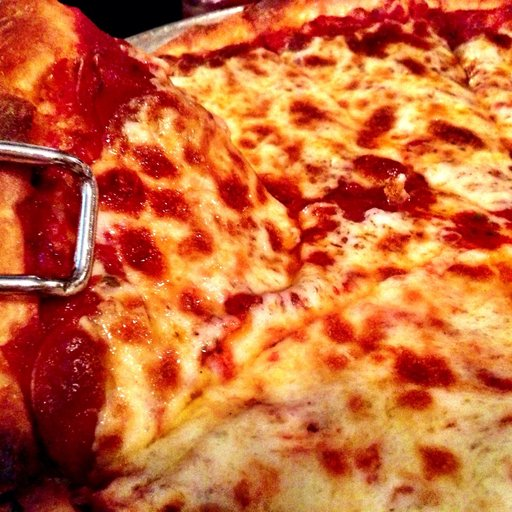

In [18]:
import random
from PIL import Image


# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

> **Note**: We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

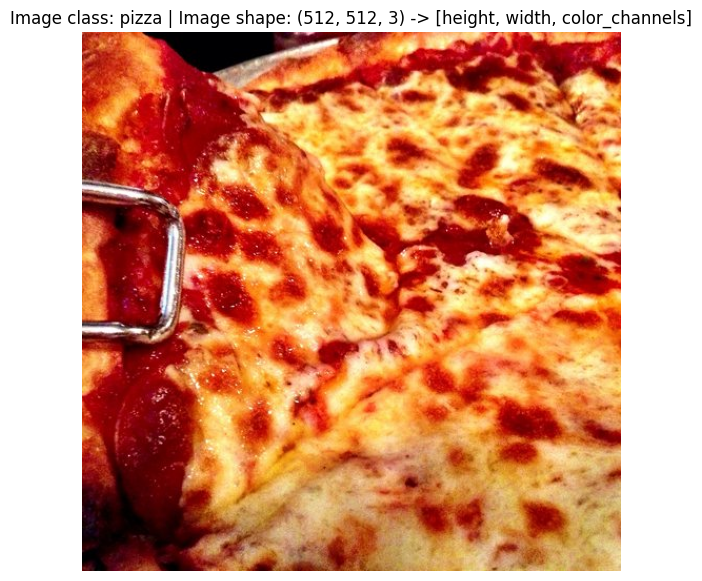

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data


Before we can use our image data with PyTorch we need to:

1. Turn it into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.


| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |



In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`



In [21]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Now we've got a composition of transforms, let's write a function to try them out on various images.

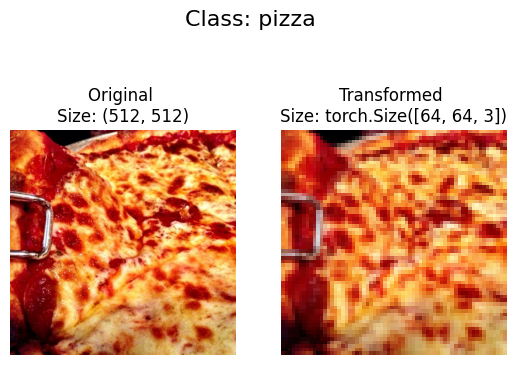

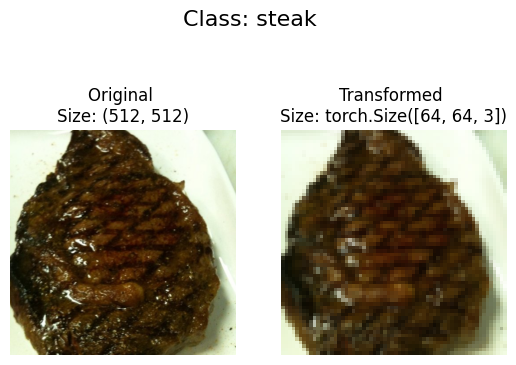

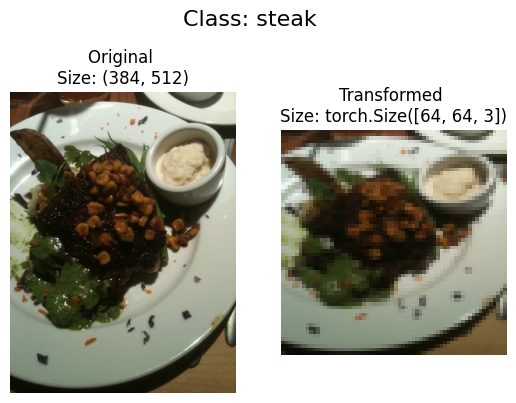

In [22]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3,
                            seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: PyTorch default is [C, H, W] but Matplotlib is [H, W, C]
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)



In [23]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets


train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [24]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [25]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [26]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [28]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Image tensor:\n{img}")


Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>
Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941

Original shape:
 torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape:
 torch.Size([64, 64, 3]) -> [height, width, color_channels]


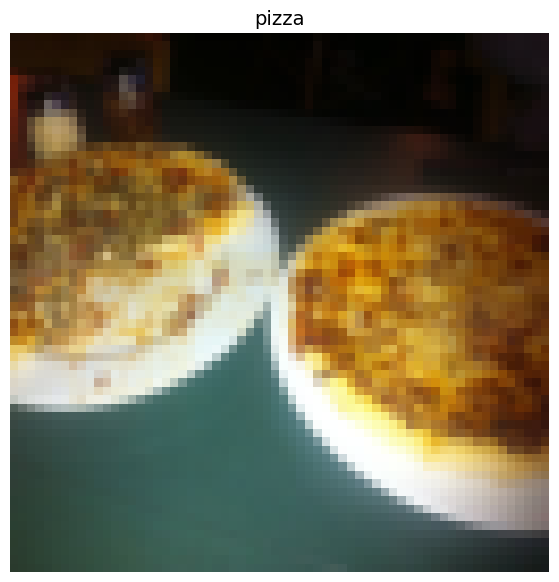

In [29]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape:\n {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape:\n {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

> **Note**: `num_workers` defines how many subprocesses will be created to load your data, usually set it to the total number of CPUs on my machine via Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).



In [31]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x791d7fe814c0>,
 <torch.utils.data.dataloader.DataLoader at 0x791d7fe815b0>)

In [33]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape:\n {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape:\n {label.shape}")

Image shape:
 torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape:
 torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

Let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.



In [34]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [35]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [36]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [37]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [38]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Woohoo! Looking good!

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

Let's do it!

In [39]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [40]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [41]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x791d7fe833b0>,
 <__main__.ImageFolderCustom at 0x791d7fd9ccb0>)

In [42]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [43]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [44]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}


We could check for equality with the `Dataset`'s made by the `torchvision.datasets.ImageFolder()` class too.

In [45]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [46]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

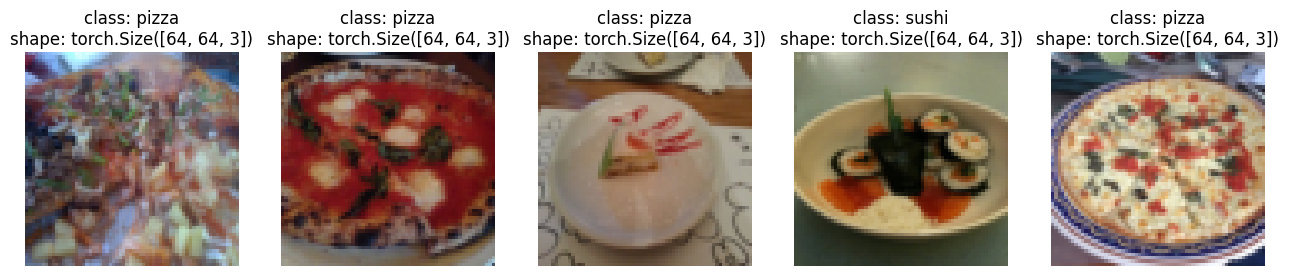

In [47]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


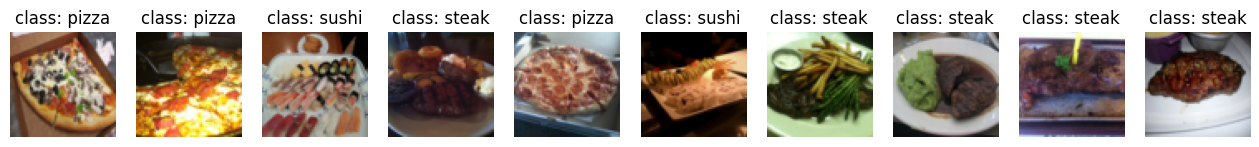

In [48]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into `DataLoader`'s



In [49]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader


train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x791d7fe82fc0>,
 <torch.utils.data.dataloader.DataLoader at 0x791d7fbe2e70>)

In [50]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape:\n {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape:\n {label_custom.shape}")

Image shape:
 torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape:
 torch.Size([1])


## 6. Other forms of transforms (data augmentation)

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

[`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).



[Transforms example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).

[`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment)  [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)

In [52]:
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

> **Note:** You usually don't perform data augmentation on the test set. The idea of data augmentation is to to *artificially* increase the diversity of the training set to better predict on the testing set.
>
> However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).



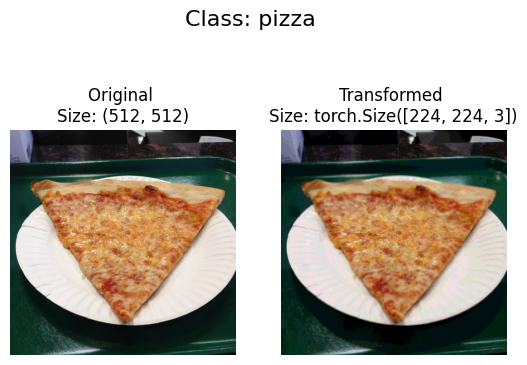

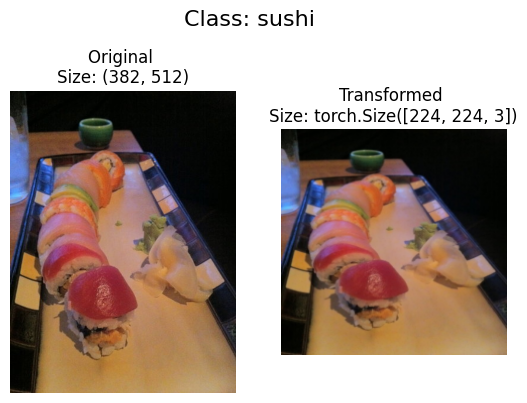

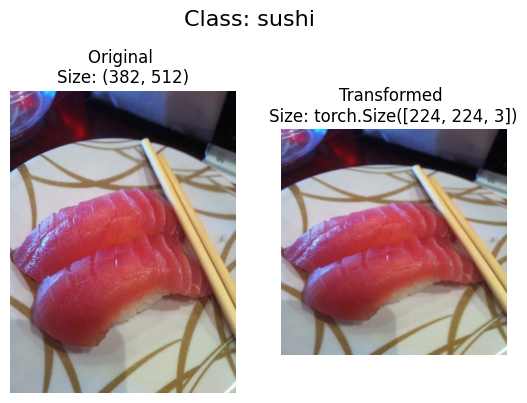

In [53]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation


To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### 7.1 Creating transforms and loading data for Model 0

In [55]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Excellent, now we've got a simple transform, let's:
1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
    * We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [56]:
from torchvision import datasets

import os
from torch.utils.data import DataLoader
# 1. Load and transform data

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# 2. Turn data into DataLoaders
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x791d7fbaf8f0>,
 <torch.utils.data.dataloader.DataLoader at 0x791d7fcc8c80>)

### 7.2 Create TinyVGG model class



In [57]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
>
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.



### 7.3 Try a forward pass on a single image (to test the model)

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [63]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape:\n {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Logits:\n {pred}\n")
print(f"Pprediction probabilities:\n {torch.softmax(pred, dim=1)}\n")
print(f"Prediction label:\n {torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Real label:\n {label_single}")

Single image shape:
 torch.Size([1, 3, 64, 64])

Logits:
 tensor([[0.0632, 0.0599, 0.0366]], device='cuda:0')

Pprediction probabilities:
 tensor([[0.3366, 0.3355, 0.3278]], device='cuda:0')

Prediction label:
 tensor([0], device='cuda:0')

Real label:
 1


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

Get information from our model using[`torchinfo`](https://github.com/TylerYep/torchinfo).

> `torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

> **Note:** If you're using Google Colab, you'll need to install `torchinfo`.

In [64]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary


summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions


Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.



In [66]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

> **Note**: The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.
But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

In [68]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`


Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled



In [73]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1}\n"
            f" train_loss: {train_loss:.4f}\n"
            f" train_acc: {train_acc:.4f}\n"
            f" test_loss: {test_loss:.4f}\n"
            f" test_acc: {test_acc:.4f}\n"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0



In [74]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)
).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer


start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
 train_loss: 1.1078
 train_acc: 0.2578
 test_loss: 1.1362
 test_acc: 0.2604

Epoch: 2
 train_loss: 1.0846
 train_acc: 0.4258
 test_loss: 1.1622
 test_acc: 0.1979

Epoch: 3
 train_loss: 1.1153
 train_acc: 0.2930
 test_loss: 1.1695
 test_acc: 0.1979

Epoch: 4
 train_loss: 1.0989
 train_acc: 0.4141
 test_loss: 1.1343
 test_acc: 0.1979

Epoch: 5
 train_loss: 1.0990
 train_acc: 0.2930
 test_loss: 1.1433
 test_acc: 0.1979

Total training time: 4.303 seconds


### 7.8 Plot the loss curves of Model 0



In [75]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll need to extract each of these keys and turn them into a plot.

In [76]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

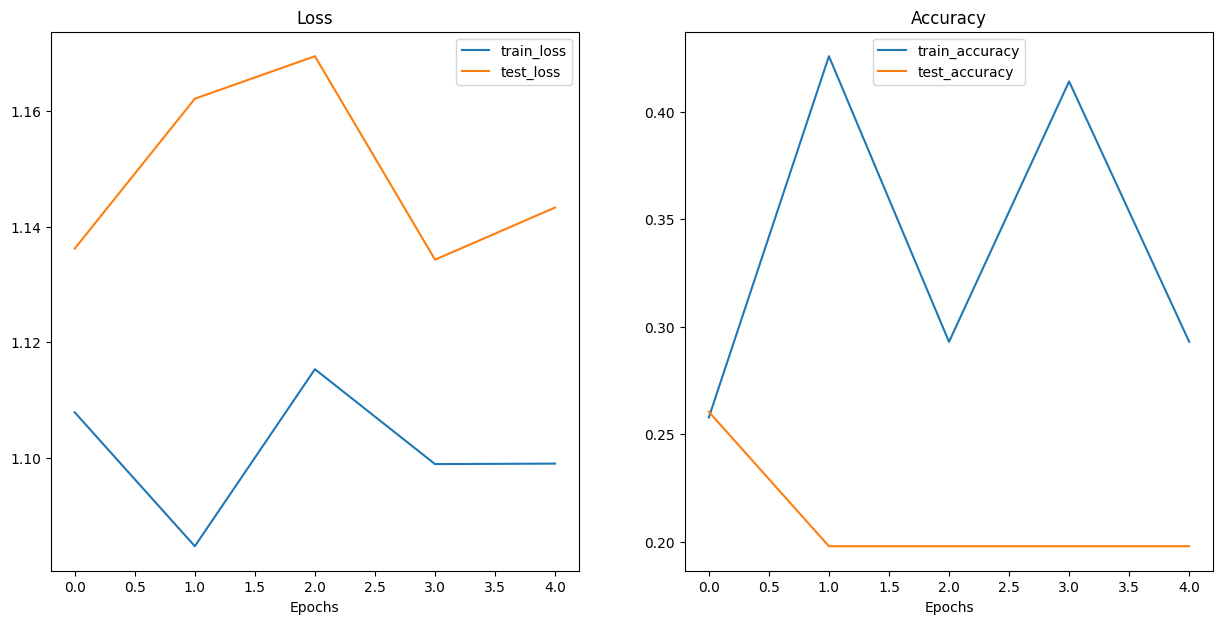

In [77]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

If your training loss is far lower than your test loss, your model is **overfitting**.

> **Note**: Looking at training and test loss curves is a great way to see if your model is **overfitting**. An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.
As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

> The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 8.1 How to deal with overfitting


A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).


| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |


### 8.2 How to deal with underfitting

Looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

> **Note**: When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.
In essence, an underfitting model will fail to reduce the loss values to a desired level.

> The main idea behind dealing with underfitting is to *increase* your model's predictive power.


| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### 8.3 The balance between overfitting and underfitting


Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.



## 9. Model 1: TinyVGG with Data Augmentation


First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

In [80]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s



In [84]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir,
                                            transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

print(train_data_augmented)
print(test_data_simple)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
# Turn Datasets into DataLoader's
import os


BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f53c6d64040>,
 <torch.utils.data.dataloader.DataLoader at 0x7f53c0b9de50>)

### 9.3 Construct and train Model 1



In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer


start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1058 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1382 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0803 | train_acc: 0.4258 | test_loss: 1.1685 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1285 | train_acc: 0.3047 | test_loss: 1.1623 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0880 | train_acc: 0.4258 | test_loss: 1.1472 | test_acc: 0.2604
Total training time: 4.924 seconds


### 9.4 Plot the loss curves of Model 1

Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

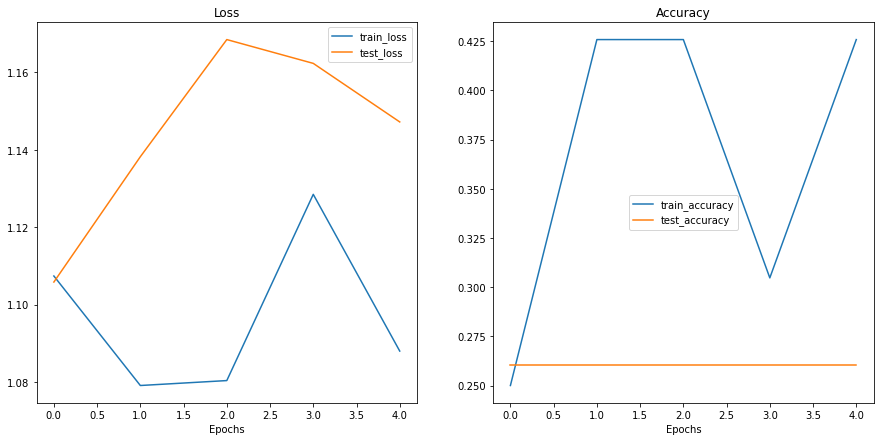

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results into pandas DataFrames.

In [ ]:
import pandas as pd


model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084713,0.425781,1.162014,0.197917
2,1.115697,0.292969,1.169704,0.197917
3,1.095564,0.414062,1.138373,0.197917
4,1.098520,0.292969,1.142631,0.197917


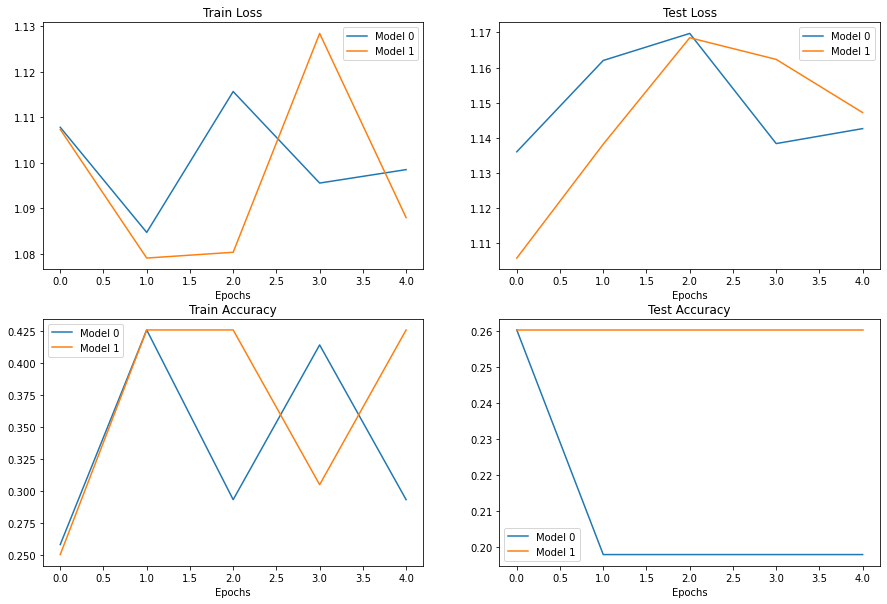

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image



In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

Excellent!

Looks like we've got a custom image downloaded and ready to go at `data/04-pizza-dad.jpeg`.

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).

Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.

Let's try it out.

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image shape\n {custom_image_uint8.shape}")
print(f"Custom image dtype:\n {custom_image_uint8.dtype}")
print(f"Custom image tensor:\n {custom_image_uint8}\n")


Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [ ]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image shape\n {custom_image.shape}")
print(f"Custom image dtype:\n {custom_image.dtype}")
print(f"Custom image tensor:\n {custom_image}\n")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model



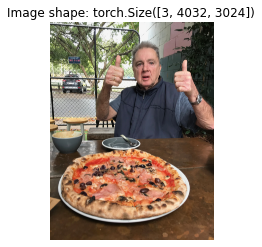

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape:\n {custom_image.shape}")
print(f"New shape:\n {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)


> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

Let's fix that by putting our `custom_image_transformed` on the target device.

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)


```
RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)
```


We can add a batch size dimension using `torch.unsqueeze(dim=0)` to add an extra dimension our image and *finally* make a prediction.



In [ ]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape:\n {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape:\n {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])



> **Note:** Three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.


In [ ]:
custom_image_pred

tensor([[ 0.1172,  0.0160, -0.1425]], device='cuda:0')

Alright, these are still in *logit form* (the raw outputs of a model are called logits).

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [ ]:
# Print out prediction logits
print(f"Prediction logits:\n {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities:\n {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label:\n {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1172,  0.0160, -0.1425]], device='cuda:0')
Prediction probabilities: tensor([[0.3738, 0.3378, 0.2883]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [ ]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3738, 0.3378, 0.2883]], device='cuda:0')

### 11.3 Putting custom image prediction together: building a function



Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.



In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred:\n {class_names[target_image_pred_label.cpu()]}\n Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred:\n {target_image_pred_label}\n Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

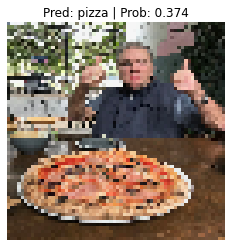

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Main takeaways


* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing `torch.utils.data.Dataset`.
* `torch.utils.data.DataLoader`'s in PyTorch help turn your `Dataset`'s into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
    2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
    3. **Wrong devices** - Your model is on the GPU but your data is on the CPU.

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb)
* [Example solutions notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.
2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.
3. Recreate `model_0` we built in section 7.
4. Create training and testing functions for `model_0`.
5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
    * Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.
6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?
7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
    * **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
    * You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.
8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
    * Does the model you trained in exercise 7 get it right?
    * If not, what do you think you could do to improve it?

## Extra-curriculum

* To practice your knowledge of PyTorch `Dataset`'s and `DataLoader`'s through PyTorch [datasets and dataloaders tutorial notebook](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
* Spend 10-minutes reading the [PyTorch `torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).
    * You can see demos of transforms in action in the [illustrations of transforms tutorial](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).
* Spend 10-minutes reading the PyTorch [`torchvision.datasets` documentation](https://pytorch.org/vision/stable/datasets.html).
    * What are some datasets that stand out to you?
    * How could you try building a model on these?
* [TorchData is currently in beta](https://pytorch.org/data/beta/index.html) (as of April 2022), it'll be a future way of loading data in PyTorch, but you can start to check it out now.
* To speed up deep learning models, you can do a few tricks to improve compute, memory and overhead computations, for more read the post [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He.